<a href="https://colab.research.google.com/github/LivingstonTardzenyuy/Deep-Learning-with-TensorFlow/blob/main/09_SkimLit_nlp_milestone_project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone project 2: SkimLit.

The purpose of this notebook is to build an NLP model to make reading medical abstract easier.

The paper we're replicating(the source of the dataset) is available here: https://arxiv.org/abs/1710.06071 .



In [1]:
# Confirm access to a GPU.

!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


## Get data.

Since we'll be replicating the paper above (PubMed 200k RCT), let's download the dataset used.

We can do so from the authors github. https://github.com/Franck-Dernoncourt/pubmed-rct

In [2]:
# Get the github dataset

!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25 (from 1)
Receiving objects: 100% (39/39), 177.08 MiB | 19.41 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [3]:
# Check what files are in the PubMed 20k datasets.

!ls pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.zip


In [4]:
# Start our experiments using the 20k dataset with numbers replaced by "@" sign.

data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
# Check all of the file names in the target directory.
import os

filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data.

Now we've got some text data, it's time to become one with it.

One of the best ways to become one with the data is to *Visualize Visualize Visualize*

So with that in mind, let's write a function to read in all of the lines of a target text file.

In [6]:
 # Create function to read line from doc.

 def get_lines(filename):
  """
    Read a file name and return a list of lines as a list.
  """
  with open(filename, "r") as f:
    return f.readlines()

In [7]:
train_lines = get_lines(data_dir + "train.txt")
train_lines[:10]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
len(train_lines)

210040

# Let's think about how we want our data to look.

Let's think about how we want our data to look.

one possible way is to turn our words into a list of dic.

'''
[{'line_number': 0,
    'target': 'BACKGROUND ',
    'text': 'Emotional eating is associated with overeating and the development of obesity .\n'
    total_lines': 11
}]

'''

In [9]:
def preprocess_text_with_line_numbers(filename):
  """
    Returns a list of dictionaries of abstract line data.

    Takes in filename, read it contents and sorts through each line,
    extracting things like the target label, text of the sentence,
    how many sentences are in current abstract and what sentence number the target line is.

  """
  input_lines = get_lines(filename)   # get all lines from filename
  abstract_lines = ""                 # empty list to hold lines
  abstract_samples = []               # create an empty list of abstracts.

  # Loop through each line in the target file.
  for line in input_lines:

    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""   # reset the abstract string if the line is an 1D line.
    elif line.isspace():
      abstract_line_split = abstract_lines.split("\n")      # split abstract into seperate lines.

      # iteract through each line in a single abstract.
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data  = {}
        target_text_split = abstract_line.split("\t")
        if len(target_text_split) > 1:
          line_data['target'] = target_text_split[0]  # get target label.
          line_data['text'] = target_text_split[1].lower()   # get target text and lower it.
          line_data['line_number'] = abstract_line_number
          line_data['total_lines'] = len(abstract_line_split) -1 # -1 means we start counting from 0.
          abstract_samples.append(line_data)

    else:  # if above conditions not meet. the lines contains are labelled sentences
      abstract_lines += line
  return abstract_samples


In [10]:
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")  # dev is another name for validation.
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")

len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [11]:
 # Check the first abtract of our training data.

 train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [12]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,12
1,METHODS,a total of @ patients with primary knee oa wer...,1,12
2,METHODS,outcome measures included pain reduction and i...,2,12
3,METHODS,pain was assessed using the visual analog pain...,3,12
4,METHODS,secondary outcome measures included the wester...,4,12
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,12
6,RESULTS,there was a clinically relevant reduction in t...,6,12
7,RESULTS,the mean difference between treatment arms ( @...,7,12
8,RESULTS,"further , there was a clinically relevant redu...",8,12
9,RESULTS,these differences remained significant at @ we...,9,12


In [13]:
# Distribution of labels in training data.

train_df.target.value_counts()

,count
target,
METHODS,59353
RESULTS,57953
CONCLUSIONS,27168
BACKGROUND,21727
OBJECTIVE,13839


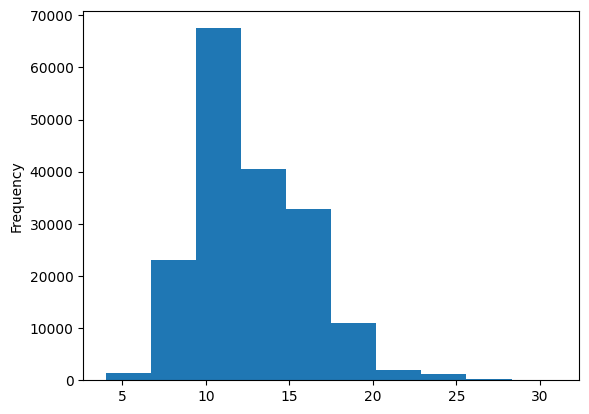

In [14]:
# Look at length of different lines.
train_df.total_lines.plot.hist();

### Get a list of sentences

In [15]:
# Convert abstract text line into list.
train_sentences = train_df.text.tolist()
val_sentences = val_df.text.tolist()
test_sentences = test_df.text.tolist()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [16]:
## View first 10 lines of training sentences.
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Making numeric labels (ML models require numeric labels ).

In [17]:
 #  One hot encode labels. We could also use tf.one_hot(tensorflow) but for now lets just use the one hot encode.

from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(
    handle_unknown='ignore')
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1)) # Call to_numpy() before reshape
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1)) # Call to_numpy() before reshape

# Check what encoded labels look like.
train_labels_one_hot

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 180040 stored elements and shape (180040, 5)>

### Label encode labels

In [18]:
# Extract labels ("target" columns) and encode them into integers.
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels = label_encoder.transform(val_df["target"].to_numpy())
test_labels = label_encoder.transform(test_df["target"].to_numpy())

# Check what encoded labels look like.
train_labels

array([3, 2, 2, ..., 4, 1, 1])

In [19]:
# Get class names and number of classes from LabelEncoder instance.
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

### Model 0: Building the baseline model using *TF-IDF Multinomial Naive Bayes*

In [20]:
# Building the GaussianNB

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline.
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

In [21]:
 # Fit the pipeline to the training data.
 model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [22]:
# evaluate baseline model on validation dataset.
model_0.score(val_sentences, val_labels)

0.7218323844829869

In [23]:
 # Make predictions using our baseline model.

 baseline_preds = model_0.predict(val_sentences)
 baseline_preds[:20]


array([4, 1, 3, 2, 2, 2, 2, 2, 4, 4, 0, 4, 1, 1, 2, 2, 4, 1, 4, 4])

### Model 2: Feature Extraction with pretrained token embeddings

Now lets use pretrained word embeddings from TensorFlow Hub, more specifically the Universal Sentece encoder:

The paper originally used GloVe embeddings, howerver, we're going to stick with the later created USE pretrained embeddings

In [27]:
# download pretrained tensorflow hub USE.

import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4",
    trainable = False,
    name="universal_sentence_encoder"
)

### Text Vectorization layer.
We want to make a layer which maps our texts from words to numbers.

In [35]:
# How many words in a Vocab ?(taken from table two of  )
max_tokens = 68000   # this number is gotton from the paper.
output_seq_len = 55
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(
    max_tokens = max_tokens,   # number of words in vocab.
    output_sequence_length = output_seq_len
)


In [36]:
# ADapt text vectorizer to training sentences.
text_vectorizer.adapt(train_sentences)

In [37]:
# Test out text vectorizer on ranom sentences.
import random
target_sentence = random.choice(train_sentences)
print(f"Original sentence: {target_sentence}")
print(f"Vectorized sentence: {text_vectorizer([target_sentence])}")

Original sentence: asparaginase and steroids can cause hypertriglyceridaemia in children with acute lymphoblastic leukaemia ( all ) .
Vectorized sentence: [[14229     3  3396   171   887 13975     5   109     7   229 10687 25966
     62     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [39]:
# How many words in our training vocab.
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"First 5 words in vocab: {rct_20k_text_vocab[:5]}")
print(f"Most common words in vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
First 5 words in vocab: ['', '[UNK]', np.str_('the'), np.str_('and'), np.str_('of')]
Most common words in vocab: ['', '[UNK]', np.str_('the'), np.str_('and'), np.str_('of')]
Least common words in vocab: [np.str_('aainduced'), np.str_('aaigroup'), np.str_('aachener'), np.str_('aachen'), np.str_('aaacp')]
